# Grouping Articles into Events

## 1. Importing labelled articles

In [1]:
import pandas as pd
from urllib.parse import urlsplit
from newsplease import NewsPlease

# Load articles
articles = pd.read_csv('HamborgArticles.tsv', sep='\t')
articles["article"] = articles.apply(lambda row: NewsPlease.from_url(row.URL), axis = 1) 

not a 200 response: 404


In [2]:
# Viewing the data

articles.head(3)

,Event ID,Outlet,URL,article
0,0,LL,https://www.huffingtonpost.com/entry/mike-pomp...,<NewsArticle.NewsArticle object at 0x7f256fd5b...
1,0,L,https://www.nytimes.com/2018/04/17/world/asia/...,<NewsArticle.NewsArticle object at 0x7f256fd5b...
2,0,M,https://www.usatoday.com/story/news/politics/2...,<NewsArticle.NewsArticle object at 0x7f256fbb9...


In [3]:
# Information summary

articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Event ID  50 non-null     int64 
 1   Outlet    50 non-null     object
 2   URL       50 non-null     object
 3   article   49 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.7+ KB


In [4]:
# Investigate Null value

articles[articles["article"].isnull()]

,Event ID,Outlet,URL,article
43,8,R,http://www.foxnews.com/politics/2018/05/01/mue...,None


The error 404 from before is because one article was taken down since the URLs were compiled

Lets remove it from the dataframe

In [5]:
# Remove Event with ID 8

articles.drop(articles[articles["article"].isnull()].index, inplace = True)
articles.reset_index(drop = True, inplace = True)

Each article is associated to an Event ID.

Lets also give each article a unique ID.

For simplicity this is just set to the index

In [6]:
# Give the articles an arbitrary index

articles.reset_index(inplace = True)
articles.rename(columns={'index':'Article ID'}, inplace = True)
articles.head()

,Article ID,Event ID,Outlet,URL,article
0,0,0,LL,https://www.huffingtonpost.com/entry/mike-pomp...,<NewsArticle.NewsArticle object at 0x7f256fd5b...
1,1,0,L,https://www.nytimes.com/2018/04/17/world/asia/...,<NewsArticle.NewsArticle object at 0x7f256fd5b...
2,2,0,M,https://www.usatoday.com/story/news/politics/2...,<NewsArticle.NewsArticle object at 0x7f256fbb9...
3,3,0,R,http://www.foxnews.com/politics/2018/04/17/cia...,<NewsArticle.NewsArticle object at 0x7f256fcaf...
4,4,0,RR,http://www.breitbart.com/big-government/2018/0...,<NewsArticle.NewsArticle object at 0x7f256fbb9...


Running the NewsPlease crawler on the urls returns an *article* object. 

Lets add 3 columns for the attributes *title*, *maintext* and *date_publish* for each article object

In [7]:
articles['title']       = articles.apply(lambda row: row['article'].title, axis = 1)
articles['maintext']    = articles.apply(lambda row: row['article'].maintext, axis = 1)
articles['datepublish'] = articles.apply(lambda row: row['article'].date_publish, axis = 1)
articles['publisher']   = articles.apply(lambda row: urlsplit(row['URL']).netloc.split(".")[1], axis = 1)

In [8]:
# lets drop URL and article as we wont be using them in this notebook

articles.drop(["URL", "article"], axis=1, inplace = True)
articles.head()

,Article ID,Event ID,Outlet,title,maintext,datepublish,publisher
0,0,0,LL,CIA Director Mike Pompeo Secretly Met With Nor...,CIA Director Mike Pompeo met in secret with Ki...,2018-04-18 00:27:59,huffingtonpost
1,1,0,L,"Mike Pompeo, C.I.A. Director, Met With Kim Jon...","WEST PALM BEACH, Fla. — President Trump dispat...",2018-04-18 00:36:07,nytimes
2,2,0,M,Mike Pompeo made top-secret visit to North Kor...,"Mike Pompeo, Trump's secretary of State pick, ...",2018-04-17 14:41:26,usatoday
3,3,0,R,CIA Director Mike Pompeo met with Kim Jong Un ...,CIA Director Mike Pompeo met with North Korean...,2018-04-17 22:15:00,foxnews
4,4,0,RR,Report: Mike Pompeo Secretly Met with Kim Jong...,"CIA Director Mike Pompeo, now President Donald...",2018-04-18 02:08:31,breitbart


## 2. Word preprocessing
The goal for the remainder of this notebook is to see if we can group the articles into events such that they closely resemble the original Event ID label given to them.

Before computing similarity metrics the text has to be processed. For this we will:
1. Remove punctuation
2. Remove stop words
3. Tokenize the words

In [9]:
import nltk
import string

nltk.download('punkt')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /home/luisgarchi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/luisgarchi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [11]:
def remove_punctuation(text):
    
    # Removes punctuation (str -> str)
    
    remove_punctuation = string.punctuation + "‘’’—“”"
    return text.lower().translate(str.maketrans('', '', remove_punctuation))


# We have to remove the punctation from stop words because 
# punctuation will be remove from the text, 
# inorder for them to match they must be processed the same (or removed before)

sw = [remove_punctuation(word) for word in stopwords.words('english')]



def tokenize_number_words(text, number, sw):
    
    # Tokenizes words, removes stop words and returns the first n number of tokens (str -> list)
    
    tokenized = word_tokenize(text)
    
    i = 0
    while i < number and i < len(tokenized):
        if tokenized[i] in sw: 
            del tokenized[i]
        else: 
            i += 1
    
    if number < len(tokenized):
        del tokenized[number:]
    
    return tokenized

In [12]:
# Test functions on a sample article
text = articles.iloc[1].maintext

print("1. Maintext: \n \n" + text[:200])

print("\n2. Remove punctuation: \n \n" + remove_punctuation(text[:200]))

punc_and_token  = tokenize_number_words(remove_punctuation(text), 50, sw)

print(f"\n3. Remove punctuation and tokenize: \n \n {punc_and_token}")

1. Maintext: 
 
WEST PALM BEACH, Fla. — President Trump dispatched the C.I.A. director Mike Pompeo to North Korea to meet with its leader, Kim Jong-un, in recent weeks to lay the groundwork for a summit meeting betwe

2. Remove punctuation: 
 
west palm beach fla  president trump dispatched the cia director mike pompeo to north korea to meet with its leader kim jongun in recent weeks to lay the groundwork for a summit meeting betwe

3. Remove punctuation and tokenize: 
 
 ['west', 'palm', 'beach', 'fla', 'president', 'trump', 'dispatched', 'cia', 'director', 'mike', 'pompeo', 'north', 'korea', 'meet', 'leader', 'kim', 'jongun', 'recent', 'weeks', 'lay', 'groundwork', 'summit', 'meeting', 'mr', 'kim', 'mr', 'trump', 'two', 'people', 'briefed', 'secret', 'trip', 'said', 'tuesday', 'mr', 'trump', 'alluded', 'mr', 'pompeos', 'mission', 'said', 'tuesday', 'afternoon', 'united', 'states', 'direct', 'talks', 'north', 'korea', 'extremely']


In [13]:
articles["body50"] = articles.apply(lambda row: tokenize_number_words(remove_punctuation(row.maintext), 50, sw), axis = 1)

# 3. Cosine Similarity
Now that we have a way of extracting the most important words of a piece of text we can go about computing a similarity matrix

In [15]:
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

%matplotlib inline
sns.set()

In [16]:
cv = CountVectorizer(analyzer=lambda x: x)

def compute_cosine_CV(article_A, article_B, vectorizer):
    
    # (string, string, vectorizer) - > int
    
    vector_matrix = vectorizer.fit_transform([article_A, article_B])
    
    return cosine_similarity(vector_matrix)[0,1]

In [17]:
# Test on two similare articles

docA = articles.iloc[0].body50
docB = articles.iloc[1].body50

print(compute_cosine_CV(docA, docB, cv))

0.3344968040028363


In [18]:
# Test on two different articles

docC = articles.iloc[6].body50

compute_cosine_CV(docA, docC, cv)

0.0502518907629606

The Simarity score works as intended since **score(docA, docB) >> score(docA, docC)**

In [19]:
def compute_cosine_matrix(corpus, vectorizer = "CV"):
    
    if vectorizer == "CV":
        vectorize = CountVectorizer(analyzer=lambda x: x)
        
    elif vectorizer == "TFIDF":
        vectorize = TfidfVectorizer(analyzer=lambda x: x)
        
    vector_matrix = vectorize.fit_transform(corpus)
    
    return cosine_similarity(vector_matrix)



"""
# Inefficient

def compute_cosine_matrix(dataframe):
    
    num_articles = dataframe.shape[0]
    cosine_matrix = np.zeros((num_articles, num_articles))

    for i, article_A in dataframe.reset_index(drop = True).iterrows():
        for j, article_B in dataframe.reset_index(drop = True).iloc[i+1:, :].iterrows():
            cosine_matrix[i, j] = compute_cosine_CV(article_A.body50, article_B.body50, cv)
    
    return cosine_matrix
    
"""

def cosine_similarity_heatmap(dataframe, cosine_matrix, size_numbers = 7):
    
    #https://towardsdatascience.com/how-to-compute-text-similarity-on-a-website-with-tf-idf-in-python-680b3be06091#:~:text=A%20simple%20and%20effective%20approach,with%20TF%2DIDF%20and%20Pandas&text=Calculating%20the%20similarity%20between%20two,natural%20language%20processing%20(NLP).
    
    similarity_df = pd.DataFrame(cosine_matrix, columns=dataframe["Article ID"], index=dataframe["Article ID"])
    mask = np.tril(np.ones_like(similarity_df)) # we apply a mask to remove the top of the heatmap

    plt.figure(figsize=(15, 15))

    sns.heatmap(
        similarity_df,
        square=True, 
        annot=True, 
        robust=True,
        fmt='.2f',
        annot_kws={'size': size_numbers, 'fontweight': 'bold'},
        yticklabels = similarity_df.columns,
        xticklabels = similarity_df.columns,
        cmap="YlGnBu",
        mask=mask
    )

    plt.title('Similarity heatmap', fontdict={'fontsize': 24})
    plt.show()

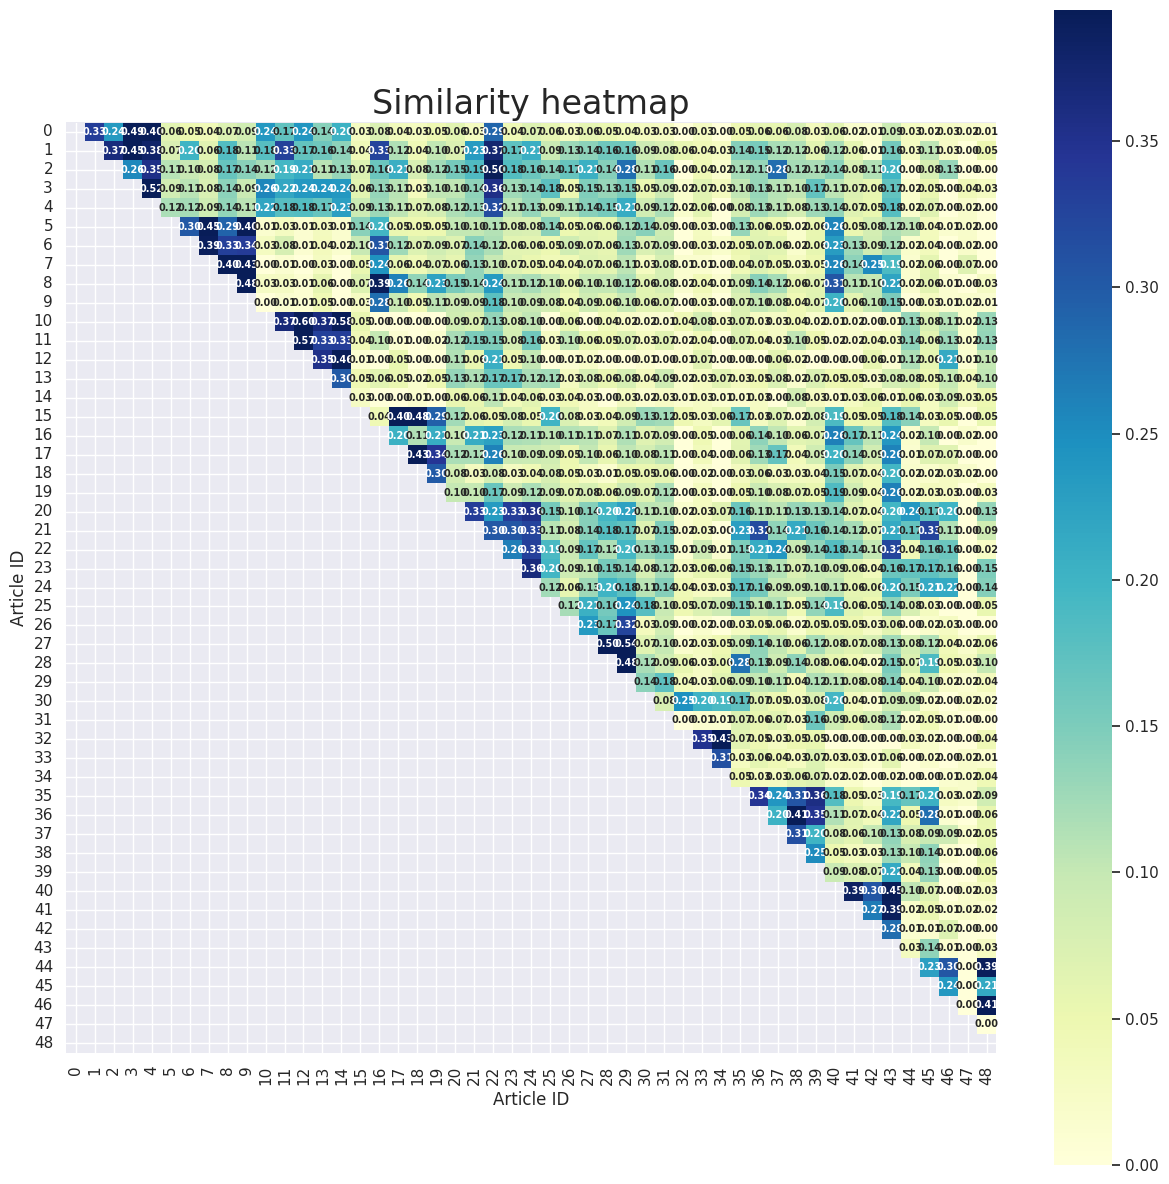

In [21]:
cv_cosine_matrix = compute_cosine_matrix(articles["body50"], vectorizer = "CV")
cosine_similarity_heatmap(articles, cv_cosine_matrix)

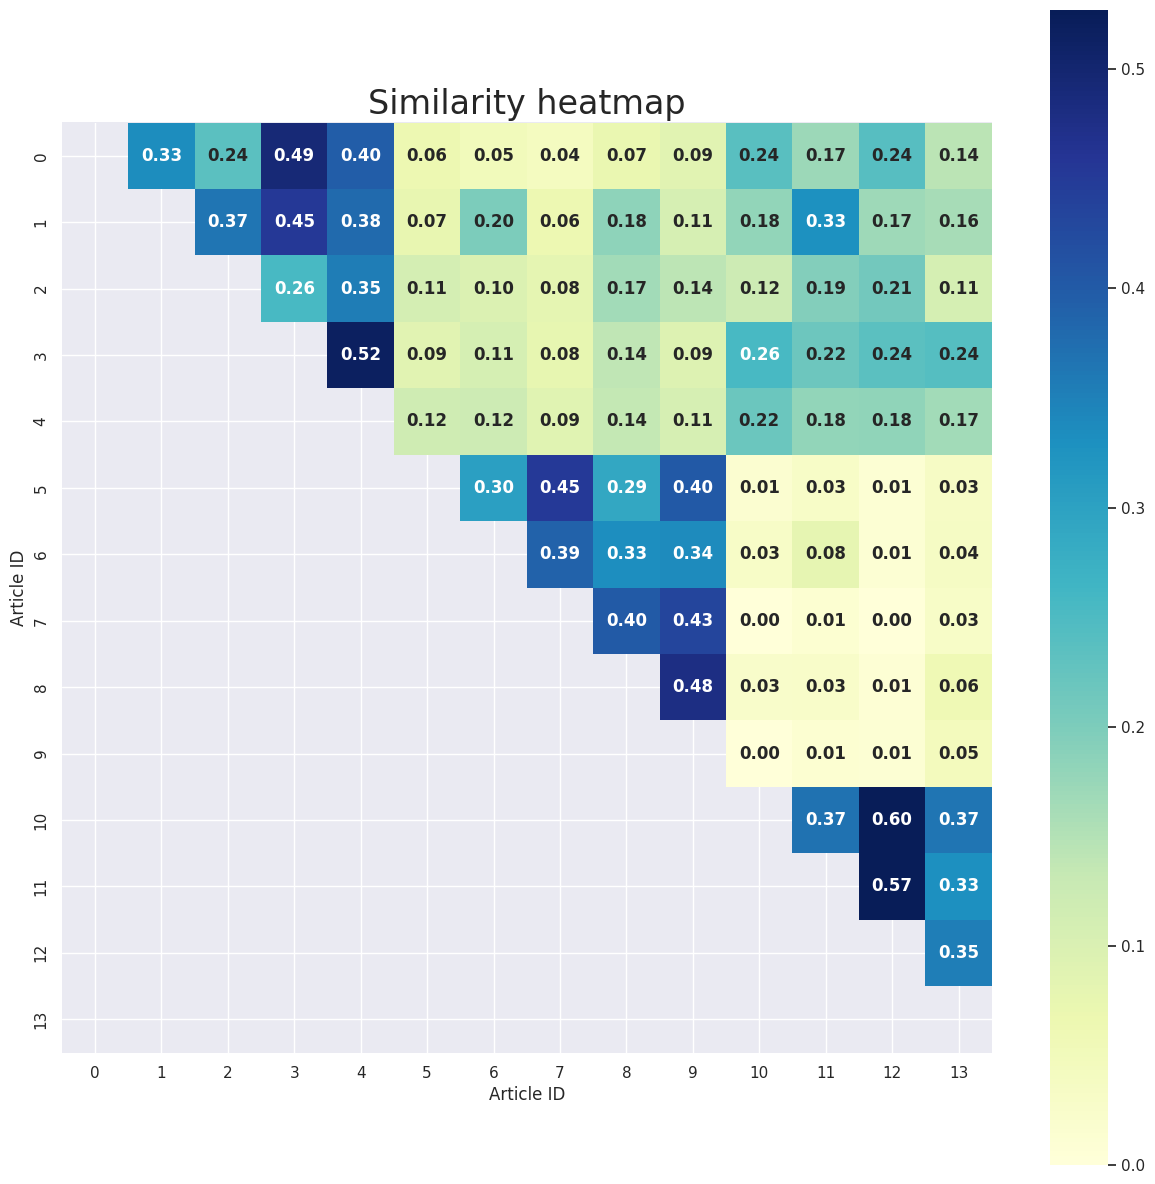

In [22]:
events1_2_3 = articles.iloc[np.r_[0:14]].reset_index(drop = True)
cosine_events1_2_3 = compute_cosine_matrix(events1_2_3["body50"], vectorizer='CV')
cosine_similarity_heatmap(events1_2_3, cosine_events1_2_3, size_numbers = 12)

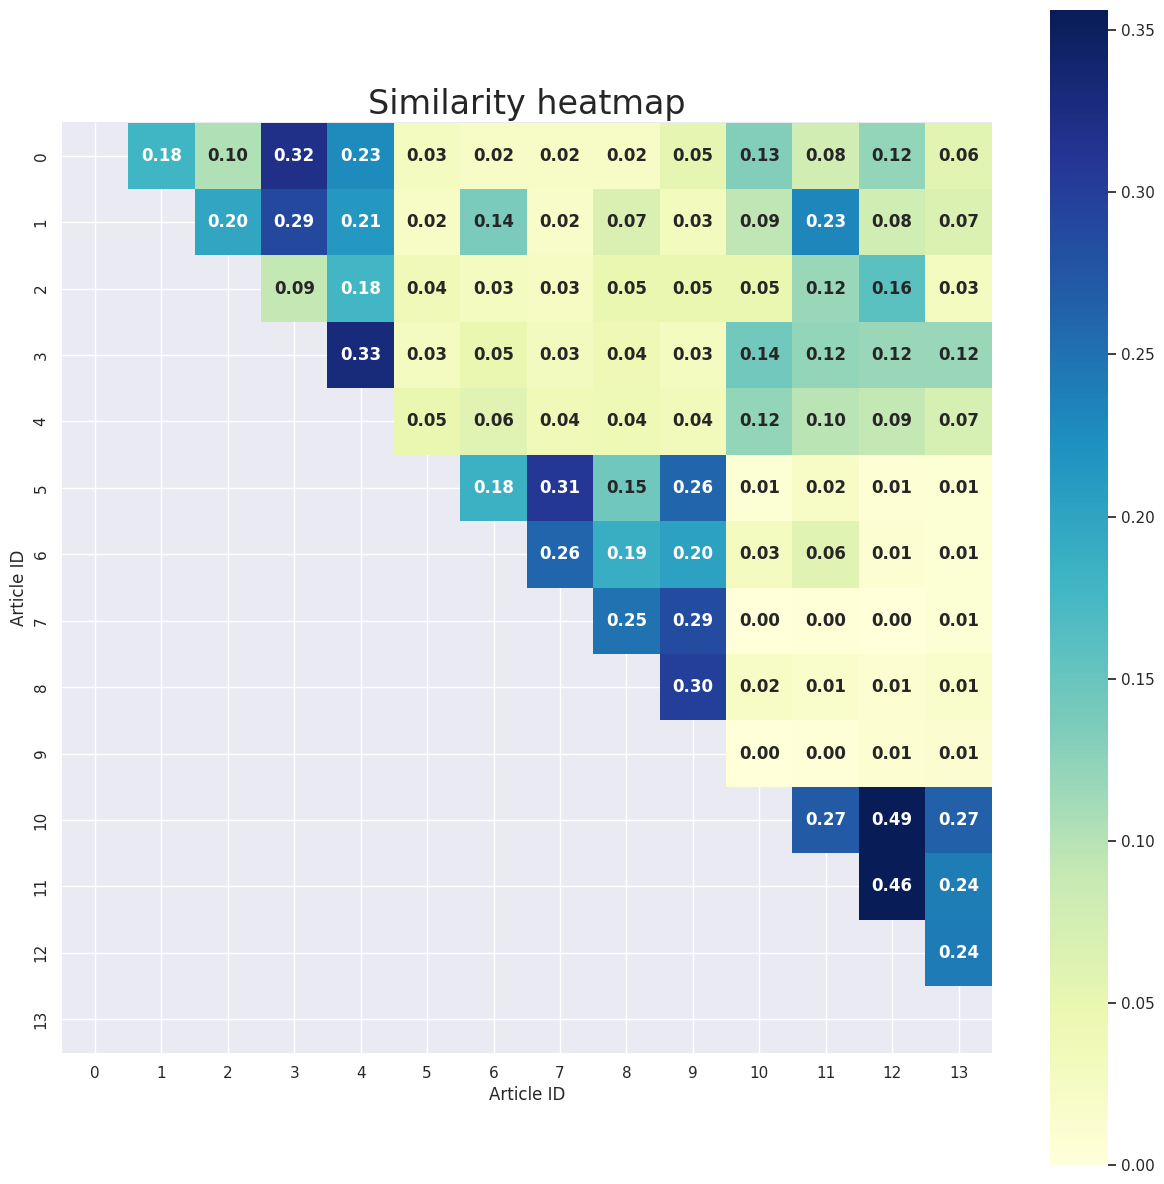

In [23]:
events1_2_3 = articles.iloc[np.r_[0:14]].reset_index(drop = True)
cosine_events1_2_3 = compute_cosine_matrix(events1_2_3["body50"], vectorizer='TFIDF')
cosine_similarity_heatmap(events1_2_3, cosine_events1_2_3, size_numbers = 12)

The cosine similarity metric behaves as expected. There is one article (47) which is an anomaly in that it is not similar to any other. The codebox below shows that the process url does not produce an article. The article is removed from the dataframe

In [20]:
articles.iloc[47].maintext

'This material may not be published, broadcast, rewritten, or redistributed. ©2023 FOX News Network, LLC. All rights reserved. Quotes displayed in real-time or delayed by at least 15 minutes. Market data provided by Factset. Powered and implemented by FactSet Digital Solutions. Legal Statement. Mutual Fund and ETF data provided by Refinitiv Lipper.'

In [21]:
articles.drop([47], inplace = True)
articles.reset_index(inplace = True, drop = True)

## 4. General Pipeline
1. Sort the articles by date.
2. Take the first article and find all articles published within 24 hours 
3. Find article pairs that have over a 0.3 cosine simlarity rating.
    - If there are none remove/discard the article from the algorithm.
    - Store the pairs of IDs for matched articles (including the original one).
    - If there is one or more, compute the cosine of the found articles for the rest of the list
        - No need to compute against the first article (already done)
        - Still need to compute cosine between any articles found (if the number of articles found is more than 1).
    - Step 3 is repeated until we find all articles that have a cosine similarity greater than 0.3 stemming from the original article.
4. Construct a graph and find communities. If there is more than one community we take the one that includes the original article. The community of articles found can be considered an event.
5. Remove/discard the found event articles from the algorithm.
6. Go back to step 2, keep repeating until there are not articles left to process.

Questions:
- How to handle articles from the same publisher?

### 4.1. Steps 1 and 2

In [22]:
# Function for step 2

def timeFrame(date, dataframe, datecolumn, delta = (1, 'D')):
    
    """
    (date, df, string, dateDelta) -> df
    
    Return all articles within the start date and the specified date delta
    """ 
    
    date_delta = np.timedelta64(delta[0], delta[1])
    plus_date_delta = date + date_delta
    
    return dataframe[(dataframe[datecolumn].values >= date) & (dataframe[datecolumn].values <= plus_date_delta)].reset_index(drop = True)



# Function for step 3

def findSimilarArticles(df, cosine_threshold, vectorizer = "CV"):
    
    """
    (df, int) -> [(int, int)]
    
    Given a df sorted by date as input,
    find pairs of articles with a cosine 
    similarity score above the threshold.
    
    The algorithm starts off with the earliest dated article, 
    and computes the cosine similarity against all other articles in the df.
    - Article pairs above the threshold are stored (by ID)
    - Additionally, new 'matching' articles are stored and tested in the next iteration.
    
    The algorithm continues until it finds a 'chain' 
    of mathcing articles stemming from earliest one
    """
    
    dataframe = df.reset_index(drop = True)
    
    # Initialize matching article pairs to return on completion
    pairs = []

    # Initialize article ID's to test (Initially just the first article)
    test_article_IDs = [0]
    ids = list(dataframe.index)
    

    # Store Cosine Matrix
    cosine_matrix = compute_cosine_matrix(dataframe["body50"], vectorizer = vectorizer)
    

    # Loop until there are no articles left to test
    while test_article_IDs and ids:
        
        # Get the article to test 
        index_A = test_article_IDs[0]
        id_A = dataframe.iloc[index_A]["Article ID"]
    
        # Test the article against all others
        for index_B, article_B in dataframe.iloc[ids].iterrows():
            
            # Skip testing the article against itself
            if index_A == index_B:
                continue
            
            cosine_score = cosine_matrix[index_A][index_B]
            
            if (cosine_score > cosine_threshold):
                
                id_B = article_B["Article ID"]
                
                # Save the pairs of matching articles
                pairs.append((id_A, id_B, cosine_score))
                
                # Skip adding matching article to test list if previously added
                if index_B not in test_article_IDs:
                    test_article_IDs.append(index_B)
        
        # Since article A has just been tested against all others it is discarded.
        test_article_IDs.remove(index_A)
        ids.remove(index_A)

    
    return pairs


### 4.2. Clustering Article Pairs
A problem arises when a matched article, also matches another article belonging to a separate event. This happens with **article ID 22** in the example below. Note that in this example we have not filtered by date. Rather event Ids 0 and 4 have been chosen to illustrate this hypothetical scenario.

In this scenario article 22 should be clusted with articles 0-4 (as they are a closer match)

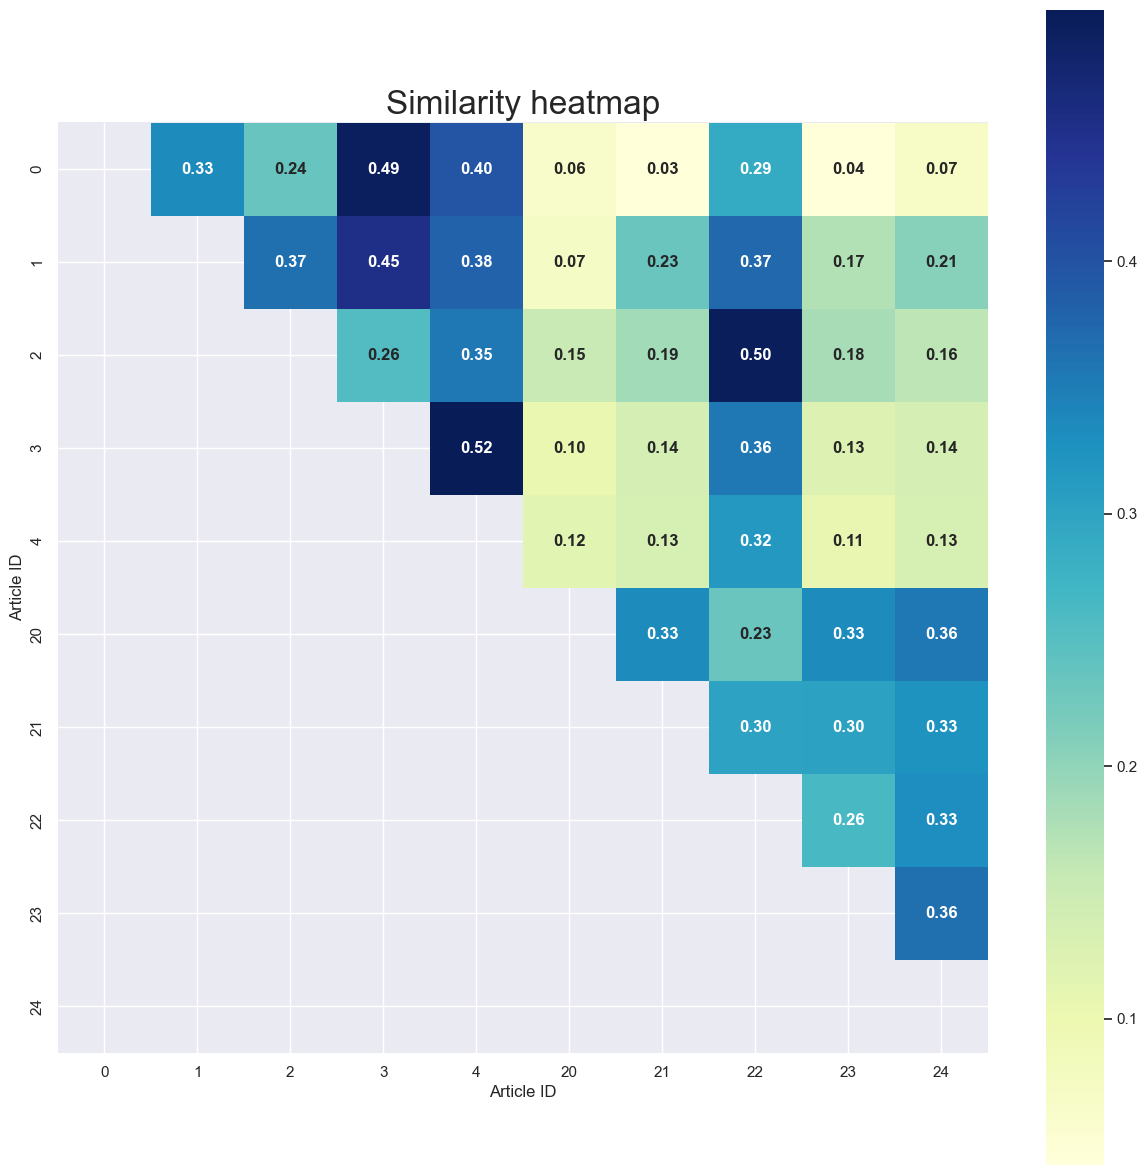

In [23]:
events1_2_3 = articles.iloc[np.r_[0:5, 20:25]].reset_index(drop = True)
cosine_events1_2_3 = compute_cosine_matrix(events1_2_3["body50"])
cosine_similarity_heatmap(events1_2_3, cosine_events1_2_3, size_numbers = 12)

In [24]:
cluster_example = findSimilarArticles(events1_2_3.copy(), 0.3)

#### Visualising the clusters

In [25]:
import networkx as nx

def plot_graph(pairs):
    
    """
    [(int, int)] -> None
    
    Plot a graph with the article ids as nodes 
    and the pairs of matching articles as edges in the graph
    """
    
    G = nx.Graph()
    G.add_weighted_edges_from(pairs)
    nx.draw_networkx(G, with_labels = True, node_color = 'r', node_size = 100)

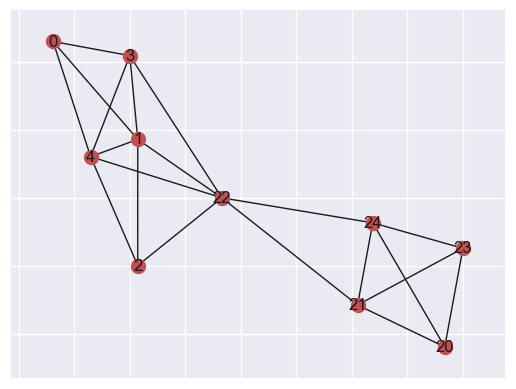

In [26]:
plot_graph(cluster_example)

There are two distinct cluster of articles and therefore a way is needed to separate them and get the cluster which contains the original article in question. In graph theory these clusters are known as communities.

In [27]:
def relatedArticles(original_article_id, pairs):
    
    """
    [(int, int)] -> [int]
    
    Take a list of matching pairs of articles and plot a graph,
    with the articles as nodes and the pairs as edges.
    
    Separate the graph into communities and return the community
    containing the original article.
    """
    
    # Construct graph, add edges
    G = nx.Graph()
    G.add_weighted_edges_from(pairs)
    
    # Split into communities
    
    if len(G.nodes) > 5: 
        
        communities = nx.community.louvain_communities(G, weight = "weight", resolution = 0.5)

        # Return community containing the original article
        for item in communities:
            if original_article_id in item:
                return list(item)
    else:
        return list(G.nodes)

In [28]:
relatedArticles(0, cluster_example)

[0, 1, 2, 3, 4, 22]

By using the function relatedArticles it is possible to reduce the number of articles into those most closely related which in general will be on the same event.

###  4.3. Bringing it all together
Lastly a function can be used to chain together a processing pipeline to cluster groups of news articles.

In [29]:
class Event:
    
    """
    Create an event class to store event specific information 
    (ids, pairs cosine similarity...)
    """
    
    
    def __init__(self, article_IDs, article_pairs, dataframe):
        self.article_IDs = article_IDs
        self.article_pairs = article_pairs
        self.dataframe = dataframe
        self.totalpublishers  = dataframe["publisher"].nunique()
        self.date = dataframe["datepublish"].min()
        self.title = dataframe[dataframe["datepublish"] == dataframe["datepublish"].min()].title.values[0]

        
        

def remove_pairs(events, pairs):
    
    """
    ([int], [(int, int, int)]) -> [(int, int, int)]
    
    Drop all pairs of articles if they either article (or neither) is in events
    """
    
    new_pairs = []
    
    for pair in pairs:
        if (pair[0] in events) and (pair[1] in events):
            new_pairs.append(pair)
    
    return new_pairs



def groupNewArticles(NewsArticles, cosine_threshold):
    
    """
    (df, int) -> [[int]]
    
    Take a collection of articles and process for grouping
    1. Sort the articles
    2. For the first article get all articles within a day
    3. Find all similar articles by computing the cosine similarity
    4. Ensure all articles are found are related to original by clustering
    5. Store the articles and repeat step 2 until all articles are processed
    """
    
    
    events = []
    
    # Sort
    articles_sorted_date = NewsArticles.sort_values(by=['datepublish']).reset_index(drop = True)
    
    i = 0
    while not articles_sorted_date.empty:
        
        original_article = articles_sorted_date.iloc[0]
        original_article_id = original_article["Article ID"]
        
        # Filter by date
    
        earliest_date = original_article["datepublish"]
        
        articles_24hours = timeFrame(earliest_date, articles_sorted_date, "datepublish")
        
        # Get similar articles by building a "chain" of similar articles
        article_pairs = findSimilarArticles(articles_24hours, cosine_threshold = cosine_threshold)
        

        if article_pairs:
                
            # Construct a graph and find the articles that form a community about the original article
            event_articles_ids = relatedArticles(original_article_id, article_pairs)

            #store the pairs of articles that form the event
            filtered_pairs = remove_pairs(event_articles_ids, article_pairs)
            
            storeDF = articles_24hours[articles_24hours["Article ID"].isin(event_articles_ids)].reset_index(drop = True)
            
            events.append(Event(event_articles_ids, filtered_pairs, storeDF))
            
            # Discard the found articles from the algorithm
            drop_articles = event_articles_ids
        else:
            # Article has no other matches drop it from the algorithm
            drop_articles = [original_article_id]
    
        
        # Discard found articles from the remainder of the algorithm
        articles_sorted_date.drop(articles_sorted_date[articles_sorted_date["Article ID"].isin(drop_articles)].index, inplace = True)
        
    return events

In [30]:
events = groupNewArticles(articles, 0.3)

In [31]:
for event in events:
    print(event.article_IDs)

[2, 1, 4, 3, 0]
[16, 5, 6, 7, 8, 9]
[11, 13, 14, 10, 12]
[18, 17, 15, 19]
[23, 21, 24, 22]
[28, 27, 29]
[33, 34]
[44, 46, 48]
[43, 41, 40, 42]
[38, 36, 37, 35]


In [32]:
events[0].title

'Mike Pompeo made top-secret visit to North Korea, report says'

### 4.4. Evaluating performance

In [33]:
# Manually label events

labels = [0, 1, 2, 3, 4, 5, 6, 9, 8, 7]

results = {}

for i, event in enumerate(events):
    results[labels[i]] = event.article_IDs

results

{0: [2, 1, 4, 3, 0],
 1: [16, 5, 6, 7, 8, 9],
 2: [11, 13, 14, 10, 12],
 3: [18, 17, 15, 19],
 4: [23, 21, 24, 22],
 5: [28, 27, 29],
 6: [33, 34],
 9: [44, 46, 48],
 8: [43, 41, 40, 42],
 7: [38, 36, 37, 35]}

In [34]:
true_groups = {}

for i, row in articles.iterrows():
    if row["Event ID"] not in true_groups:
        true_groups[row["Event ID"]] = []

    true_groups[row["Event ID"]].append(row["Article ID"])
    
true_groups

{0: [0, 1, 2, 3, 4],
 1: [5, 6, 7, 8, 9],
 2: [10, 11, 12, 13, 14],
 3: [15, 16, 17, 18, 19],
 4: [20, 21, 22, 23, 24],
 5: [25, 26, 27, 28, 29],
 6: [30, 31, 32, 33, 34],
 7: [35, 36, 37, 38, 39],
 8: [40, 41, 42, 43],
 9: [44, 45, 46, 48]}

In [35]:
iou = []

for key in true_groups.keys():
    result = set(results[key])
    true_group = set(true_groups[key])
    
    iou.append(len(result & true_group) / len(result | true_group))

sum(iou)/len(iou)

0.7983333333333333

Has an average intersection over union score of 0.8 for each event

## 5. Testing on Unseen data

In [36]:
from dateutil import parser

In [37]:
# Preprocessing data with 160,000 articles to a smaller subset

"""

# Import the data
UK_articles = pd.read_json('articles.json')

# For efficiency lets remove 2 publisher that publish an excessive amount every day
test_articles = UK_articles[~UK_articles.publisher.isin(["dailymail", "sun"])].copy()

# Format datepublish (change from a string to a date)
test_articles["datepublish"] = pd.to_datetime(test_articles.datePublished).dt.tz_localize(None)

# Drop unnecessary columns
drop_cols = ["twitterHeadline", "description", "images", "thumbnail", "videos", "dateUpdated", "dateParsed", "datePublished"]
test_articles.drop(drop_cols, axis=1, inplace=True)

# Rename columns
test_articles.rename(columns={'body': 'maintext', 'headline': 'title'}, inplace = True)

# Give aritcles an ID
test_articles.reset_index(inplace = True)
test_articles.rename(columns={'index':'Article ID'}, inplace = True)

# For efficiency lets look at the most recent 20 days worth of articles
latest_date = test_articles.datepublish.max()
filter_date = latest_date - np.timedelta64(10, 'D')

filter_test = test_articles[test_articles["datepublish"] > filter_date].sort_values(by = "datepublish")
filter_test.reset_index(inplace = True, drop = True)

# Save
filter_test.to_json(r'UK_articles_subset.json')

"""


'\n\n# Import the data\nUK_articles = pd.read_json(\'articles.json\')\n\n# For efficiency lets remove 2 publisher that publish an excessive amount every day\ntest_articles = UK_articles[~UK_articles.publisher.isin(["dailymail", "sun"])].copy()\n\n# Format datepublish (change from a string to a date)\ntest_articles["datepublish"] = pd.to_datetime(test_articles.datePublished).dt.tz_localize(None)\n\n# Drop unnecessary columns\ndrop_cols = ["twitterHeadline", "description", "images", "thumbnail", "videos", "dateUpdated", "dateParsed", "datePublished"]\ntest_articles.drop(drop_cols, axis=1, inplace=True)\n\n# Rename columns\ntest_articles.rename(columns={\'body\': \'maintext\', \'headline\': \'title\'}, inplace = True)\n\n# Give aritcles an ID\ntest_articles.reset_index(inplace = True)\ntest_articles.rename(columns={\'index\':\'Article ID\'}, inplace = True)\n\n# For efficiency lets look at the most recent 20 days worth of articles\nlatest_date = test_articles.datepublish.max()\nfilter_dat

In [38]:
UK_articles_subset = pd.read_json('UK_articles_subset.json')

# Process the first 50 words for cosine comparison
UK_articles_subset["body50"] = UK_articles_subset.apply(lambda row: tokenize_number_words(remove_punctuation(row.maintext), 50, sw), axis = 1)

UK_articles_subset.datepublish = pd.to_datetime(UK_articles_subset.datepublish, unit = "ms")

In [39]:
events_2 = groupNewArticles(UK_articles_subset, 0.35)

## 5.1. Investigating Events

In [40]:
import random

In [41]:
# Select events that all publishers, puiblished an article about
important_events = [event for event in events_2 if event.totalpublishers >= 5]
investigate_events = random.choices(important_events, k =5)

In [42]:
for event in investigate_events:
    print("On date = ", event.date, ":\n")
    for i, row in event.dataframe.iterrows():
        print(f"Article {i} = ", row.publisher, ":", row.title)
    
    print()

On date =  2020-04-12 09:50:14 :

Article 0 =  metro : Carrie sent Boris scan of their baby as he battled coronavirus in hospital
Article 1 =  sky : Coronavirus: Boris Johnson recovering at Chequers ahead of social distancing rules review
Article 2 =  sky : Coronavirus: Boris Johnson out of hospital but won't yet return to work, says Downing Street
Article 3 =  theguardian : Boris Johnson leaves hospital as he continues recovery from coronavirus
Article 4 =  mirror : Boris Johnson discharged from hospital and will continue recovery at Chequers
Article 5 =  metro : Boris Johnson is out of hospital after fighting coronavirus in intensive care
Article 6 =  mirror : Carrie Symonds thanks NHS for getting Boris Johnson through 'dark times' in hospital
Article 7 =  independent : Boris Johnson discharged from hospital seven days after being admitted for coronavirus symptoms
Article 8 =  bbc : Coronavirus: Boris Johnson discharged from hospital
Article 9 =  mirror : BREAKING Boris Johnson says 